## 状態空間モデルで時系列予測を行う（Statsmodels）

In [1]:
# ライブラリーのインポート
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels.api as sm

In [2]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('../data/AirPassengers.csv')

# float型に変換
df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={'#Passengers': 'Passengers'})

# datetime型にしてインデックスにする
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

# データの中身を確認
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [4]:
# 日付形式にする
ts = df['Passengers'] 
ts.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: Passengers, dtype: float64

#### ローカルレベルモデルの推定

/tmp/Python/python-3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                        Unobserved Components Results                         
Dep. Variable:             Passengers   No. Observations:                  144
Model:                    local level   Log Likelihood                -705.955
Date:                Sun, 09 May 2021   AIC                           1415.909
Time:                        00:20:03   BIC                           1421.835
Sample:                    01-01-1949   HQIC                          1418.317
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.312e-07     85.482   1.53e-09      1.000    -167.542     167.542
sigma2.level      1136.4043    176.695      6.431      0.000     790.088    1482.721
Ljung-Box (L1) (Q):         

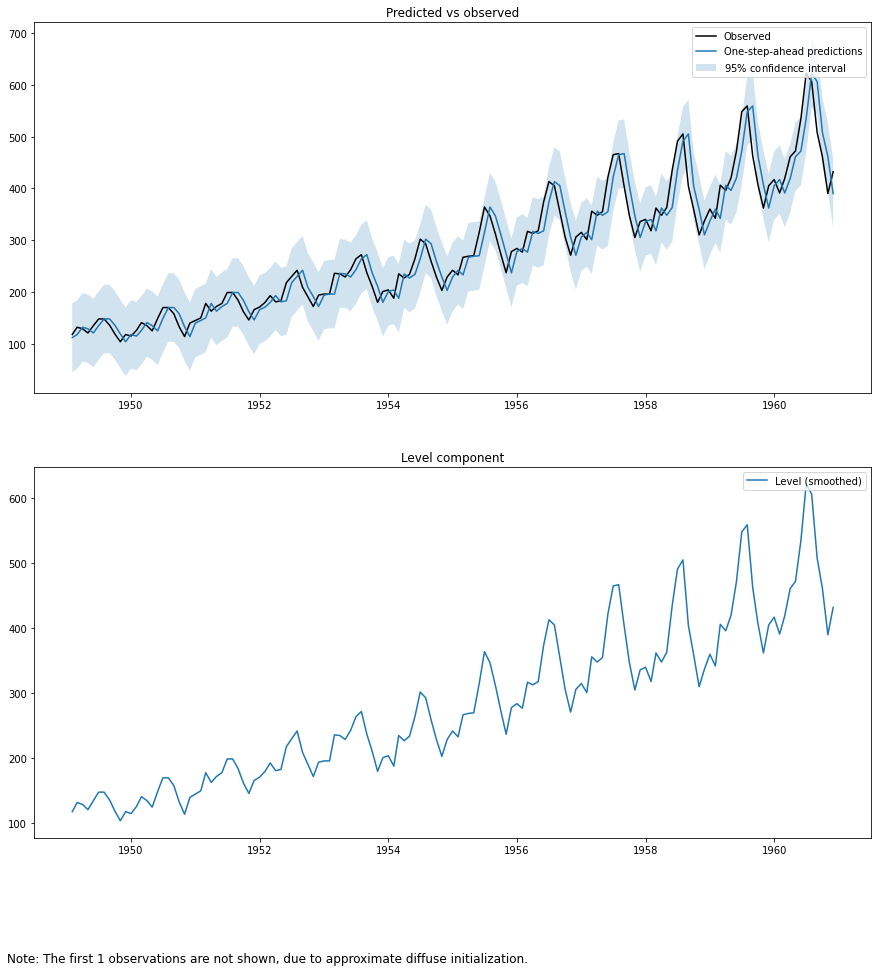

In [5]:
# ローカルレベルモデルの推定
mod_local_level = sm.tsa.UnobservedComponents(ts, 'local level')

# 最尤法によるパラメタの推定
res_local_level = mod_local_level.fit()

# 推定されたパラメタ一覧
print(res_local_level.summary())

# 推定された状態・トレンドの描画
rcParams['figure.figsize'] = 15, 15
fig = res_local_level.plot_components()

#### ローカル線形トレンドモデルの推定

/tmp/Python/python-3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 5.015259
         Iterations: 19
         Function evaluations: 30
         Gradient evaluations: 30
                        Unobserved Components Results                         
Dep. Variable:             Passengers   No. Observations:                  144
Model:             local linear trend   Log Likelihood                -722.197
Date:                Sun, 09 May 2021   AIC                           1450.394
Time:                        00:21:05   BIC                           1459.262
Sample:                    01-01-1949   HQIC                          1453.998
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    86.590

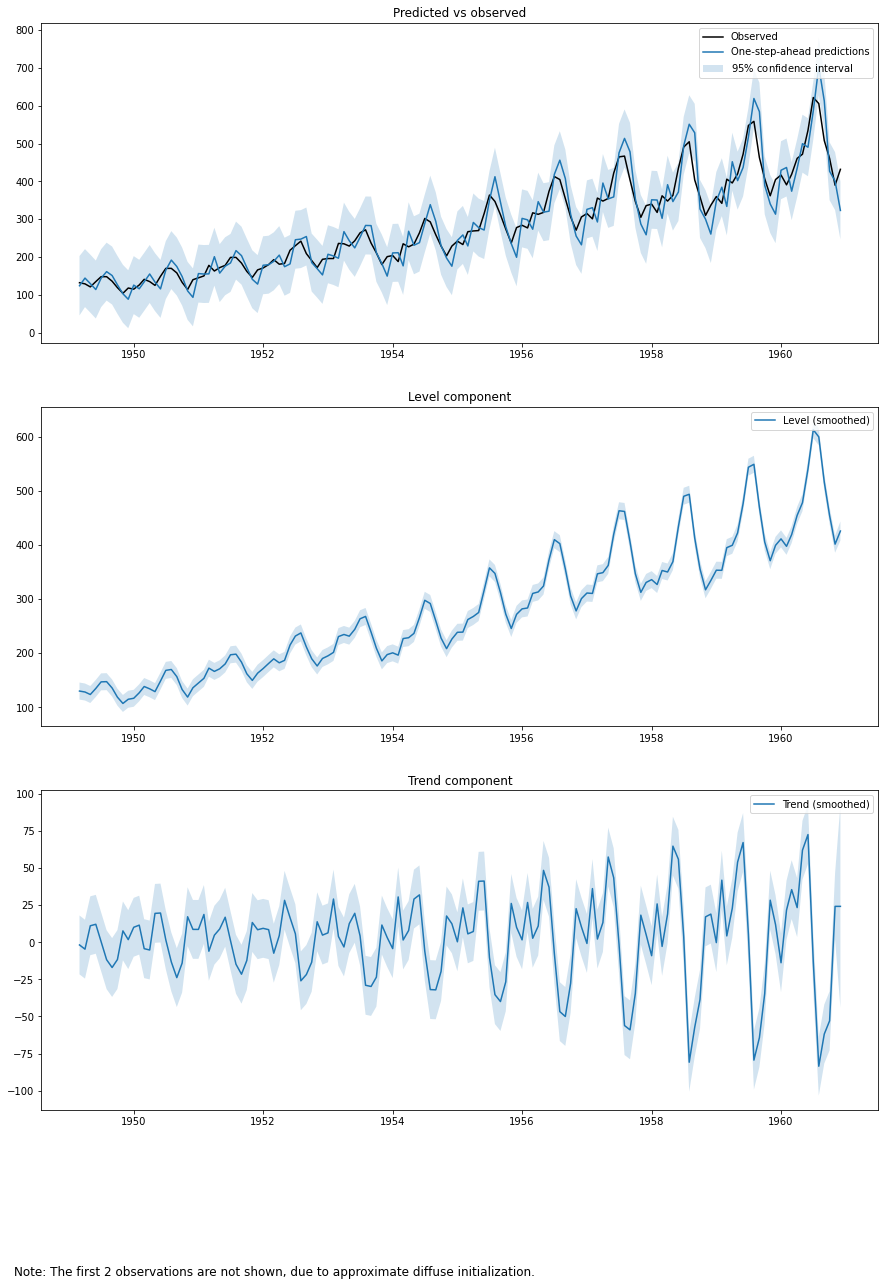

In [6]:
# ローカル線形トレンドモデル

mod_trend = sm.tsa.UnobservedComponents(
    ts,
    'local linear trend'
)

# 最尤法によるパラメタの推定
# ワーニングが出たのでBFGS法で最適化する
res_trend = mod_trend.fit(method='bfgs')

# 推定されたパラメタ一覧
print(res_trend.summary())

# 推定された状態・トレンドの描画
rcParams['figure.figsize'] = 15, 20
fig = res_trend.plot_components()

#### 季節変動の取り込み

/tmp/Python/python-3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 3.969241
         Iterations: 148
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: 3.969241
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                    Passengers   No. Observations:                  144
Model:                           local level   Log Likelihood                -571.571
                   + stochastic seasonal(12)   AIC                           1149.142
Date:                       Sun, 09 May 2021   BIC                           1157.790
Time:                               00:21:36   HQIC                          1152.656
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cov

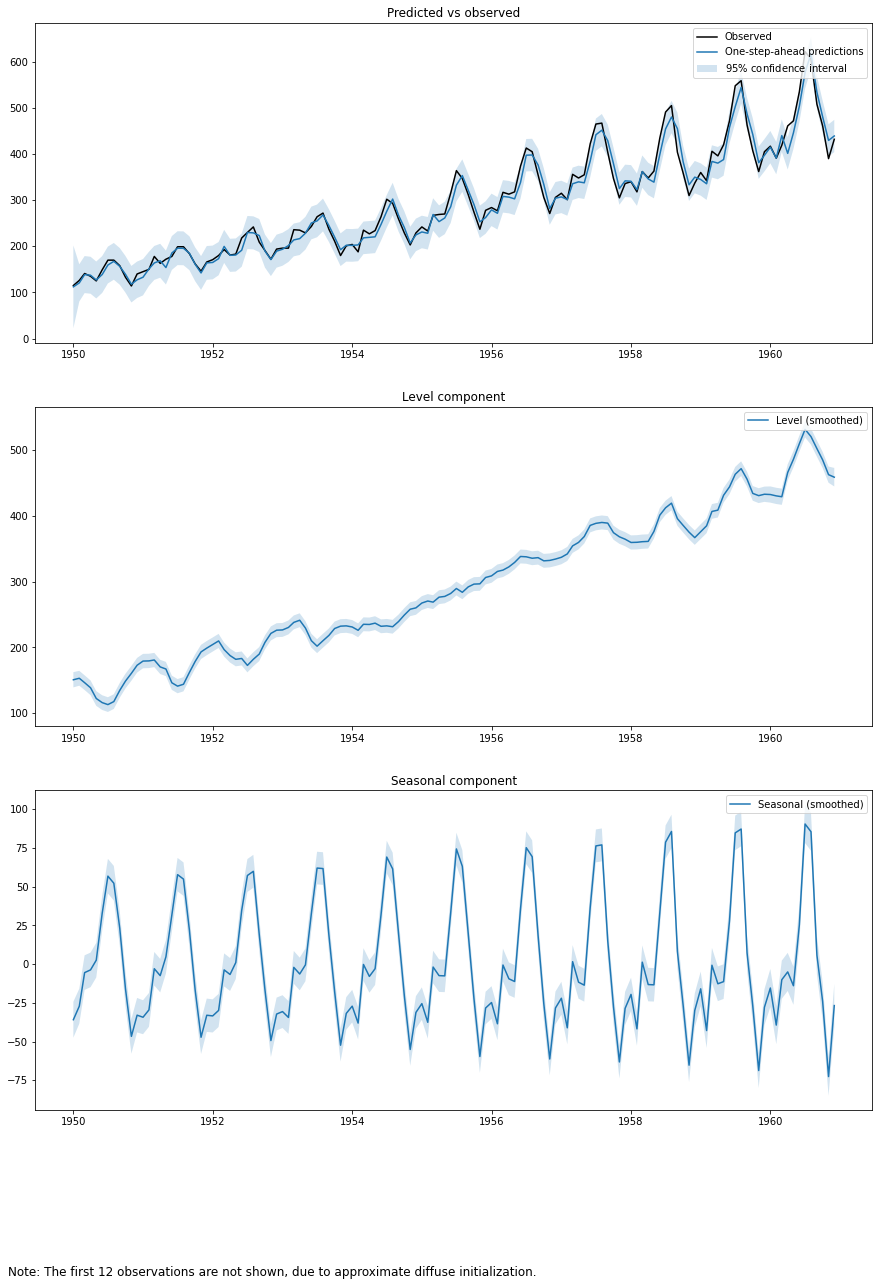

In [7]:
# 季節変動ありのローカルレベルモデル

mod_season_local_level = sm.tsa.UnobservedComponents(
    ts,
    'local level',
    seasonal=12)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_local_level = mod_season_local_level.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_local_level.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_local_level.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_local_level.plot_components()

/tmp/Python/python-3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 495
         Function evaluations: 827
Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                    Passengers   No. Observations:                  144
Model:                    local linear trend   Log Likelihood                -566.051
                   + stochastic seasonal(12)   AIC                           1140.103
Date:                       Sun, 09 May 2021   BIC                           1151.603
Time:                               00:21:52   HQIC                          1144.776
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cov

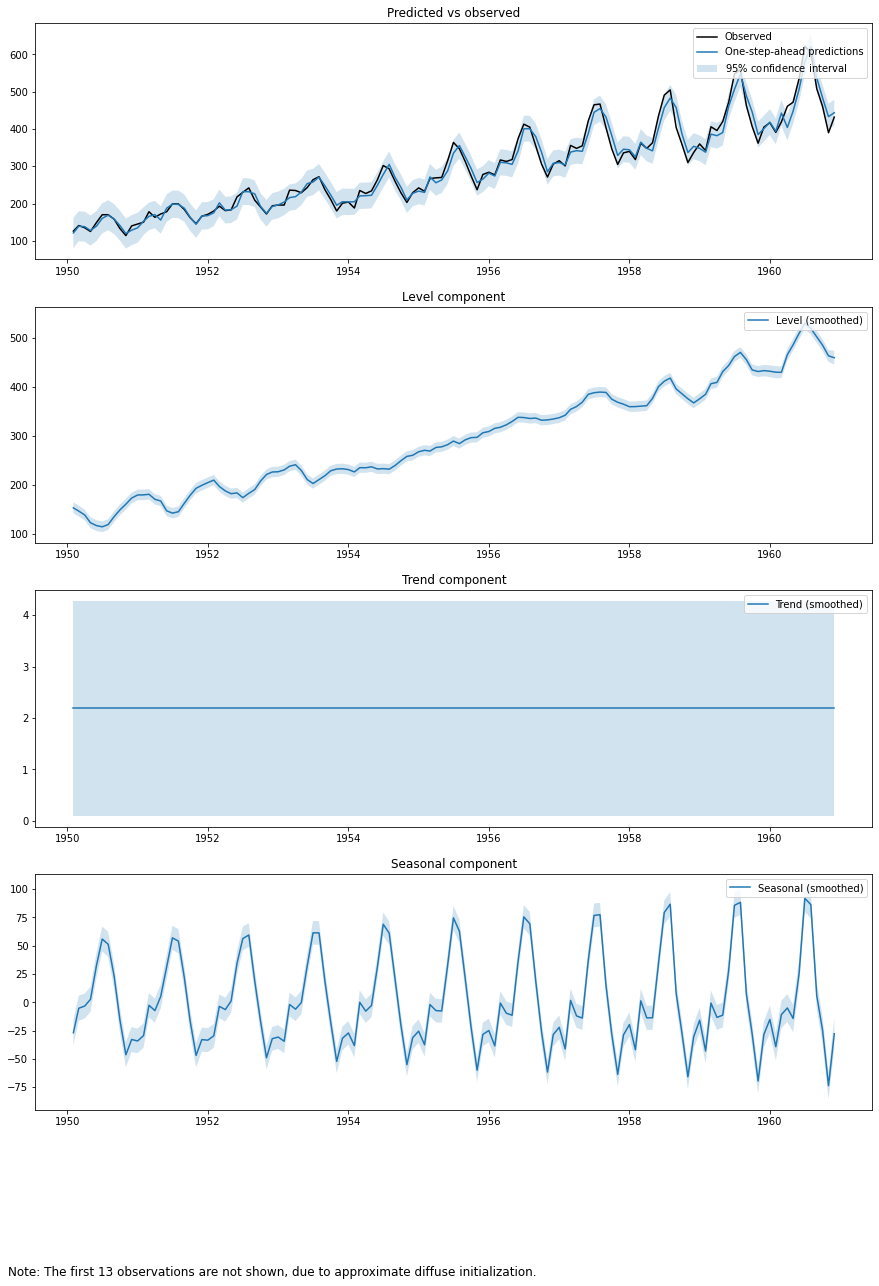

In [8]:
# 季節変動ありのローカル線形トレンドモデル

mod_season_trend = sm.tsa.UnobservedComponents(
    ts,
    'local linear trend',
    seasonal=12)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_trend = mod_season_trend.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_trend.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_trend.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_trend.plot_components()

#### 推定するパラメータ数を減らす

/tmp/Python/python-3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 115
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                               Unobserved Components Results                                
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             local linear deterministic trend   Log Likelihood                -566.051
                          + stochastic seasonal(12)   AIC                           1138.103
Date:                              Sun, 09 May 2021   BIC                           1146.728
Time:                                      00:22:25   HQIC                          1141.608
Sample:                                  01-01-1949                                         
                                       -

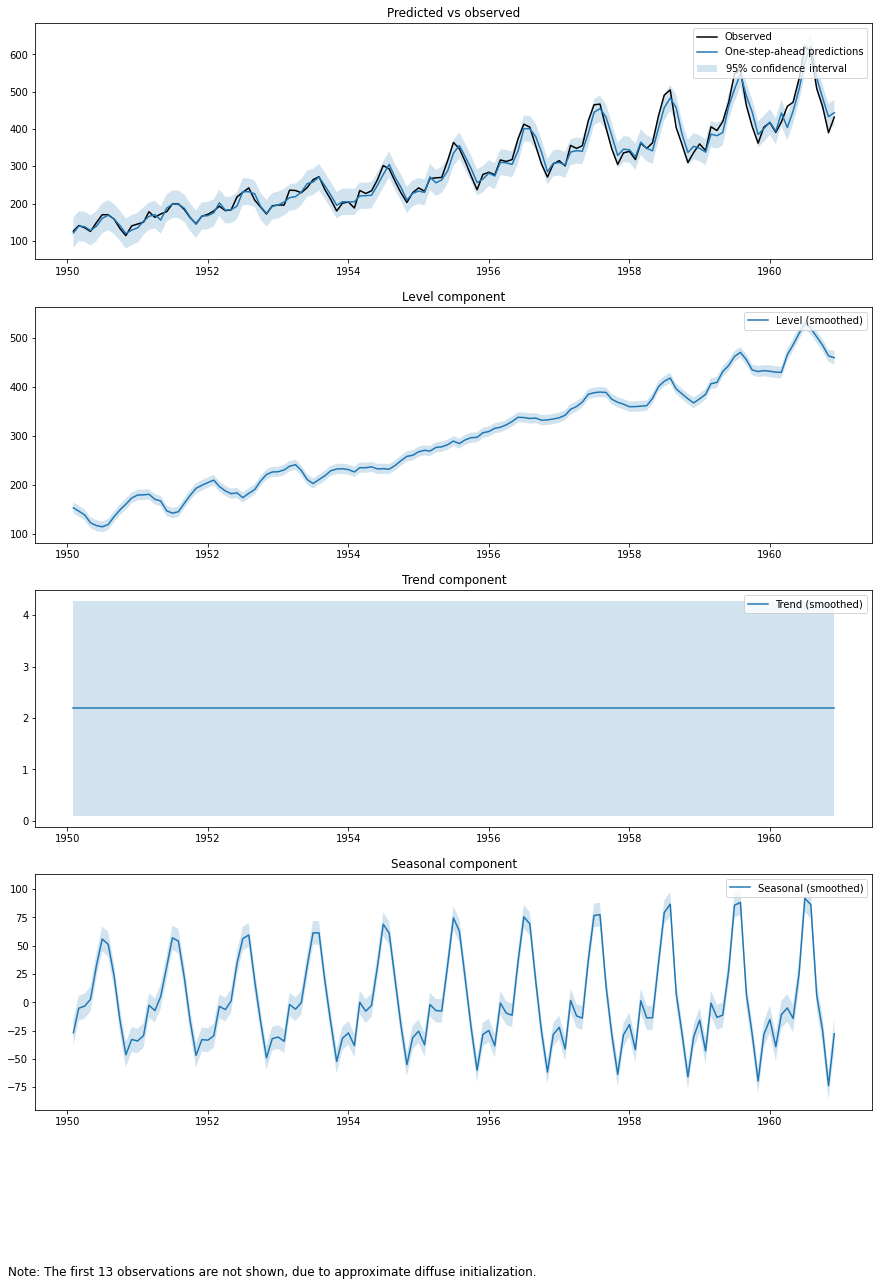

In [9]:
# 詳細は以下の資料を参照してください
# http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

# 季節変動ありのローカル線形トレンドモデル
# ただし、トレンドの分散は無し

mod_season_trend_d = sm.tsa.UnobservedComponents(
    ts,
    'local linear deterministic trend',
    seasonal=12)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_trend_d = mod_season_trend_d.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_trend_d.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_trend_d.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_trend_d.plot_components()

/tmp/Python/python-3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                    Passengers   No. Observations:                  144
Model:                random walk with drift   Log Likelihood                -566.051
                   + stochastic seasonal(12)   AIC                           1136.103
Date:                       Sun, 09 May 2021   BIC                           1141.853
Time:                               00:22:44   HQIC                          1138.439
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cova

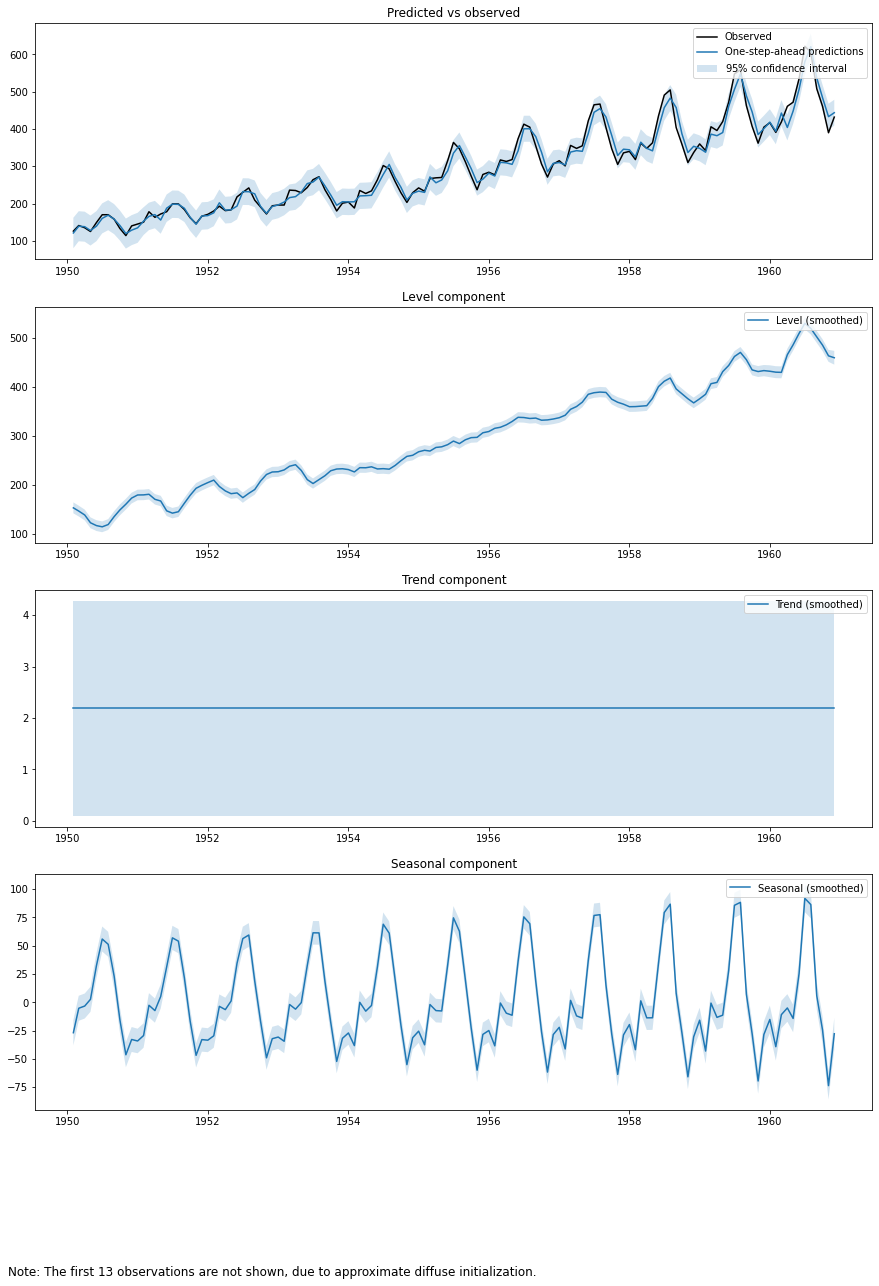

In [10]:
# 詳細は以下の資料を参照してください
# http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

# 季節変動ありのローカル線形トレンドモデル
# ただし、トレンドの分散は無し

mod_season_rw = sm.tsa.UnobservedComponents(
    ts,
    'random walk with drift',
    seasonal=12)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_rw = mod_season_rw.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_rw.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_rw.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_rw.plot_components()

#### モデルの比較と予測

In [13]:
# 今まで計算してきたモデルのAICを格納する
aic_list = pd.DataFrame(index=range(6), columns=["model", "aic"])

aic_list.iloc[0]["model"] = "res_local_level"
aic_list.iloc[0]["aic"] = res_local_level.aic

aic_list.iloc[1]["model"] = "res_trend"
aic_list.iloc[1]["aic"] = res_trend.aic

aic_list.iloc[2]["model"] = "res_season_local_level"
aic_list.iloc[2]["aic"] = res_season_local_level.aic

aic_list.iloc[3]["model"] = "res_season_trend"
aic_list.iloc[3]["aic"] = res_season_trend.aic

aic_list.iloc[4]["model"] = "res_season_trend_d"
aic_list.iloc[4]["aic"] = res_season_trend_d.aic

aic_list.iloc[5]["model"] = "res_season_rw"
aic_list.iloc[5]["aic"] = res_season_rw.aic

# 結果の表示
aic_list

,model,aic
0,res_local_level,1415.909117
1,res_trend,1450.394469
2,res_season_local_level,1149.141543
3,res_season_trend,1140.102616
4,res_season_trend_d,1138.102616
5,res_season_rw,1136.102616


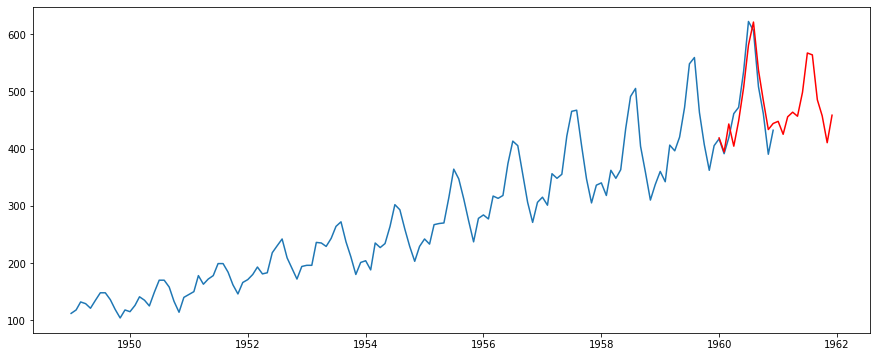

In [14]:
# 予測
pred = res_season_rw.predict('1960-01-01', '1961-12-01')

# 実データと予測結果の図示
rcParams['figure.figsize'] = 15, 6
plt.plot(ts)
plt.plot(pred, "r")